# Import Libraries

In [310]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
#
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Conv2D, MaxPooling2D,BatchNormalization, Dropout, Input, LeakyReLU

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model


# Kaggle API Token

1. Go to your Kaggle account, click on your profile picture (top right), and go to "Account" from the menu.
2. Scroll down to the "API" section and click on "Create New API Token". This will download a kaggle.json file containing your API credentials.

In [254]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abotstolemyusername","key":"a65256843f0e8e123175f5091f7e9c44"}'}

# Setup Kaggle API
Set up the Kaggle API and ensure the kaggle.json file is in the correct location with the appropriate permissions.

In [255]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Dataset

In [256]:
#kaggle datasets download -d [username/dataset-name]
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


 # Extract the Dataset

In [267]:
!unzip -q chest-xray-pneumonia.zip

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/._NORMAL? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX

# List Directories at the Root of the Unzipped Folder
Assuming the dataset is unzipped into a folder named chest_xray in the current working directory, you can list its contents using os.listdir().

In [268]:
root_dir = 'chest_xray'
os.listdir(root_dir)

['__MACOSX', 'test', 'val', 'chest_xray', 'train']

# Explore Further and List Files
To list the files in a specific directory, such as the training set for normal chest X-rays, you might do something like this:

In [269]:
train_normal_dir = os.path.join(root_dir, 'train', 'NORMAL')
train_normal_files = os.listdir(train_normal_dir)
print(train_normal_files[:4])  # List the first 10 file names


['NORMAL2-IM-0897-0001.jpeg', 'IM-0311-0001.jpeg', 'IM-0747-0001.jpeg', 'IM-0209-0001.jpeg']


In [270]:
train_pneumonia_dir = os.path.join(root_dir, 'train', 'PNEUMONIA')
train_pneumonia_files = glob.glob(train_pneumonia_dir + '/**/*.jpeg', recursive=True)
print(train_pneumonia_files[:10])  # List the first 10 file paths

['chest_xray/train/PNEUMONIA/person894_bacteria_2819.jpeg', 'chest_xray/train/PNEUMONIA/person494_virus_1000.jpeg', 'chest_xray/train/PNEUMONIA/person898_bacteria_2823.jpeg', 'chest_xray/train/PNEUMONIA/person1658_bacteria_4402.jpeg', 'chest_xray/train/PNEUMONIA/person14_bacteria_51.jpeg', 'chest_xray/train/PNEUMONIA/person420_bacteria_1849.jpeg', 'chest_xray/train/PNEUMONIA/person515_virus_1032.jpeg', 'chest_xray/train/PNEUMONIA/person351_bacteria_1617.jpeg', 'chest_xray/train/PNEUMONIA/person53_bacteria_253.jpeg', 'chest_xray/train/PNEUMONIA/person317_bacteria_1471.jpeg']


# Display Multiple Images in a Grid
To display multiple images in a grid, you can use a loop. Here's an example of displaying the first few images from a list of image paths:

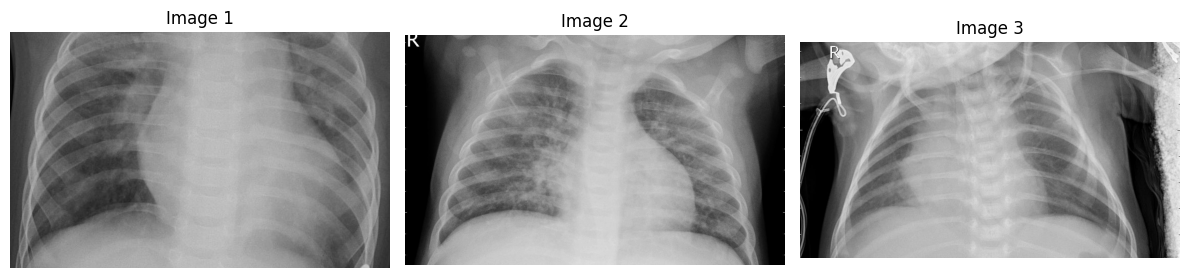

In [271]:
# Example: Display the first 3 pneumonia images from the training set
num_images = 3
fig, axes = plt.subplots(1, 3, figsize=(12, 12))  # Create a grid of 3x3

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = train_pneumonia_files[i]
        image = Image.open(image_path)
        ax.imshow(image, cmap='gray')  # Use cmap='gray' if it's a grayscale image
        ax.set_title(f'Image {i+1}')
        ax.axis('off')  # Hide the axes
    else:
        ax.axis('off')  # Hide axes for empty subplots

plt.tight_layout()
plt.show()


# Data Preprocessing
Use ImageDataGenerator to load your data and apply preprocessing required for ResNet50. You might need to adjust target_size based on the input size that ResNet50 expects (224x224). You can change the images to grayscale as needed.

In [272]:
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [337]:
# Move 24 images from the training set to the validation set
num_images = 24

normal_images = train_normal_files[:num_images]
pneumonia_images = train_pneumonia_files[:num_images]

for image in normal_images:
      source = os.path.join(train_normal_dir, image)
      dest = os.path.join(val_dir, 'NORMAL', image)
      os.rename(source, dest)

for image in pneumonia_images:
      source = image
      dest = os.path.join(val_dir, 'PNEUMONIA', os.path.basename(image))
      os.rename(source, dest)

# Check the number of images in the training and validation sets
num_train_normal = len(os.listdir(train_normal_dir))
num_train_pneumonia = len(os.listdir(train_pneumonia_dir))

num_val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
print(f'Training set: Normal - {num_train_normal}, Pneumonia - {num_train_pneumonia}')
print(f'Validation set: Normal - {num_val_normal}, Pneumonia - {num_val_pneumonia}')



Training set: Normal - 1317, Pneumonia - 3851
Validation set: Normal - 32, Pneumonia - 32


In [339]:

# Define the preprocessing function
def preprocess(image, label):
    image = preprocess_input(image)
    # apply random contrast augmentation
    image = tf.image.random_contrast(image, 0.1, 0.9)
    return image, label

# Create a dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary',
)

# Apply preprocessing, augmentation and prefetching
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Do the same for the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


Found 5168 files belonging to 2 classes.
Found 64 files belonging to 2 classes.


# Load VGG16 trained on ImageNet

In [341]:
# Load pre-trained VGG16 VGG_custom_head without head (headless)
vgg_ = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
#vgg_.trainable = False
vgg_.trainable = True

# Define input layer (adjust the shape based on your input images)
input_tensor = Input(shape=(224, 224, 3), name='input_1')

# Pass input through VGG16 base VGG_custom_head
x = vgg_(input_tensor, training=False)
x = BatchNormalization()(x)
x = Conv2D(128, (5, 5), activation='relu', name='Conv2D_1')(x)
x = Flatten()(x)
x = Dense(128, activation='relu', name='Dense_1')(x)
x = Dropout(0.5, name='Dropout_1')(x)
x = BatchNormalization()(x)
VGG_output = Dense(1, activation='sigmoid', name='Output_1')(x)

# Create the VGG_custom_head model
VGG_custom_head = Model(inputs=input_tensor, outputs = VGG_output, name='VGG16_transfer')

base_learning_rate = 0.0001

# Fine-tune layers the last 2 layers
number_of_tune_layers = 2
for layer in vgg_.layers[:-number_of_tune_layers]:
    layer.trainable = False

# Compile the VGG_custom_head
VGG_custom_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print VGG_custom_head and the base summary
vgg_.summary()
VGG_custom_head.summary()
tf.keras.utils.plot_model(VGG_custom_head, show_shapes=True)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_108 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

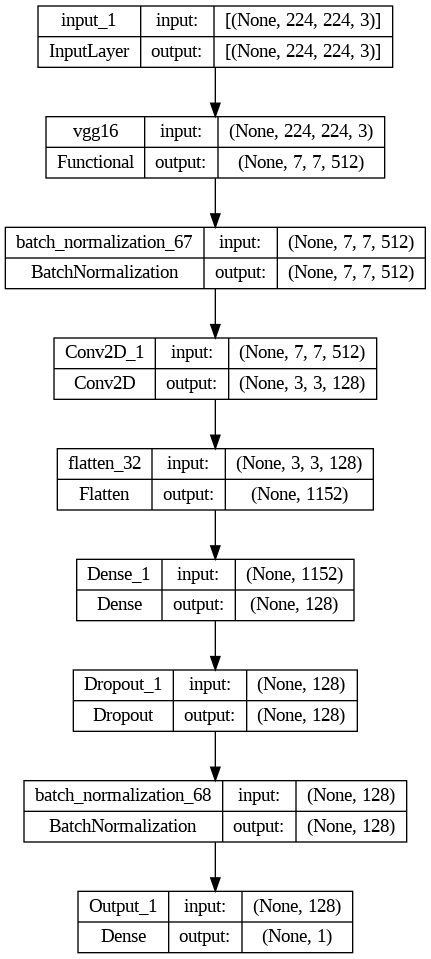

In [275]:
tf.keras.utils.plot_model(VGG_custom_head, show_shapes=True)

In [276]:
# Train the model
VGG_history = VGG_custom_head.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
163/163 [==============================] - 15s 73ms/step - loss: 0.2071 - accuracy: 0.9325 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 2/20
163/163 [==============================] - 13s 74ms/step - loss: 0.0792 - accuracy: 0.9854 - val_loss: 0.1066 - val_accuracy: 1.0000
Epoch 3/20
163/163 [==============================] - 13s 76ms/step - loss: 0.0501 - accuracy: 0.9919 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 4/20
163/163 [==============================] - 13s 75ms/step - loss: 0.0418 - accuracy: 0.9937 - val_loss: 0.0293 - val_accuracy: 1.0000


# Load the Pre-trained ResNet50 Model
Load ResNet50 with pre-trained weights from ImageNet, excluding the top (fully connected) layers. Set input_shape as required by ResNet50.

In [277]:
resnet50_ = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Fine-tune layers the last 4 layers
number_of_tune_layers = 12
for layer in resnet50_.layers[:-number_of_tune_layers]:
    layer.trainable = False

# Add Custom Layers on Top of ResNet50
Now, create a sequential model, add the pre-trained base model, and then add your custom layers on top.

In [278]:
# Add your sequential model

# Create a new model on top
Res_input = Input(shape=(224, 224, 3))
x = resnet50_(Res_input, training=False)
x = BatchNormalization()(x)
x = Conv2D(128, (5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.35)(x)
Res_outputs = Dense(1, activation='sigmoid')(x)

Res_model = Model(Res_input, Res_outputs,name='ResNet50_transfer')
base_learning_rate = 0.0001

# Compile the model
Res_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy']
   )

resnet50_.summary()
Res_model.summary()

#tf.keras.utils.plot_model(Res_model, show_shapes=True)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_105 (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_105[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [279]:
# Fit your model
Res_history = Res_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping],
)

Epoch 1/15
163/163 [==============================] - 19s 80ms/step - loss: 0.1844 - accuracy: 0.9379 - val_loss: 0.1117 - val_accuracy: 0.8750
Epoch 2/15
163/163 [==============================] - 13s 75ms/step - loss: 0.0899 - accuracy: 0.9703 - val_loss: 0.9449 - val_accuracy: 0.6250
Epoch 3/15
163/163 [==============================] - 13s 76ms/step - loss: 0.0548 - accuracy: 0.9801 - val_loss: 0.0858 - val_accuracy: 1.0000
Epoch 4/15
163/163 [==============================] - 13s 75ms/step - loss: 0.0395 - accuracy: 0.9862 - val_loss: 0.2011 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 13s 74ms/step - loss: 0.0242 - accuracy: 0.9933 - val_loss: 0.6386 - val_accuracy: 0.8125
Epoch 6/15
163/163 [==============================] - 13s 75ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.8316 - val_accuracy: 0.7500


# Prepare the Test Data
First, prepare your test data using ImageDataGenerator, similar to how you prepared the training and validation data. Make sure to use the preprocess_input function from ResNet50 for preprocessing.

In [334]:
# Add your code by following the example in the Data Preprocessing section.
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)



Found 624 files belonging to 2 classes.


# Evaluate the Model
Use the evaluate method to test the model's performance on the test set. Your model must have at least 90% accuracy.

In [281]:
# Evaluate the model
VGG_custom_head.evaluate(test_dataset, verbose=1)
Res_model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 51ms/step - loss: 0.7389 - accuracy: 0.8317


[0.7389132380485535, 0.8317307829856873]

# Plot Learning Curves
To visualize the learning curves (accuracy and loss for both training and validation), you can plot them using matplotlib. This helps in understanding overfitting, underfitting, or if the model is learning well.

In [282]:
# Add your code here or use tensorboard
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(
   x=list(range(len(VGG_history.history['accuracy']))),
   y=VGG_history.history['accuracy'],
   mode='lines',
   name='VGG16 Training Accuracy'
)

trace2 = go.Scatter(
   x=list(range(len(VGG_history.history['val_accuracy']))),
   y=VGG_history.history['val_accuracy'],
   mode='lines',
   name='VGG16 Validation Accuracy'
)

trace3 = go.Scatter(
   x=list(range(len(Res_history.history['accuracy']))),
   y=Res_history.history['accuracy'],
   mode='lines',
   name='ResNet50 Training Accuracy'
)

trace4 = go.Scatter(
   x=list(range(len(Res_history.history['val_accuracy']))),
   y=Res_history.history['val_accuracy'],
   mode='lines',
   name='ResNet50 Validation Accuracy'
)

data = [trace1, trace2, trace3, trace4]

# Define layout
layout = go.Layout(
   title='Training and Validation Accuracy for VGG16 and ResNet50',
   xaxis=dict(title='Epoch'),
   yaxis=dict(title='Accuracy'),
)

# Define figure
fig = go.Figure(data=data, layout=layout)

# Plot the figure
fig.show()


# Create a Customized Model and Evaluate It.
 Your customized model must have at least 90% accuracy.


In [344]:
# Add your code here

input_tensor = Input(shape=(224, 224, 3), name='input_01')

x = Conv2D(32, (5, 5), activation='relu', name='block_1_conv_1')(input_tensor)
x = BatchNormalization(name='block_1_batchNorm')(x)
x = MaxPooling2D((2, 2), name='block_1_maxPooling')(x)
x = Dropout(0.15, name='block_1_dropout')(x)

x = Conv2D(64, (5, 5), activation='relu', name='block_2_conv_1')(x)
x = BatchNormalization(name='block_2_batchNorm')(x)
x = MaxPooling2D((2, 2), name='block_2_maxPooling')(x)
x = Dropout(0.5, name='block_2_dropout')(x)

x = Conv2D(128, (5, 5), activation='relu', name='block_3_conv_1')(x)
x = BatchNormalization(name='block_3_batchNorm')(x)
x = MaxPooling2D((2, 2), name='block_3_maxPooling')(x)
x = Dropout(0.25, name='block_3_dropout')(x)

x = Conv2D(128, (5, 5), activation='relu', name='block_4_conv_1')(x)
x = BatchNormalization(name='block_4_batchNorm_1')(x)
x = Conv2D(128, (5, 5), activation='relu', name='block_4_conv_2')(x)
x = BatchNormalization(name='block_4_batchNorm_2')(x)
x = Conv2D(128, (5, 5), activation='relu', name='block_4_conv_3')(x)
x = BatchNormalization(name='block_4_batchNorm_3')(x)
x = MaxPooling2D((2, 2), name='block_4_maxPooling')(x)
x = Dropout(0.5, name='block_4_dropout')(x)

x = Flatten(name='Flatten')(x)
#x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu',name='fc_1')(x)
x = BatchNormalization(name='fc_batchNorm')(x)
x = Dropout(0.5, name='block_5_dropout')(x)

custom_output = Dense(1, activation='sigmoid',name='output_1')(x)
custom_model = Model(inputs=input_tensor, outputs=custom_output, name='custom_model')

base_learning_rate = 0.001

# Compile the model
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

custom_model.summary()

# Fit your model
custom_history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping],
)

# Evaluate the model
custom_model.evaluate(test_dataset, verbose=1)


Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_01 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block_1_conv_1 (Conv2D)     (None, 220, 220, 32)      2432      
                                                                 
 block_1_batchNorm (BatchNo  (None, 220, 220, 32)      128       
 rmalization)                                                    
                                                                 
 block_1_maxPooling (MaxPoo  (None, 110, 110, 32)      0         
 ling2D)                                                         
                                                                 
 block_1_dropout (Dropout)   (None, 110, 110, 32)      0         
                                                                 
 block_2_conv_1 (Conv2D)     (None, 106, 106, 64)     

[1.5016881227493286, 0.807692289352417]

In [345]:
# Use learning curves or tensorboard to visualize the performance of your customized model.
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(
   x=list(range(len(custom_history.history['accuracy']))),
   y=custom_history.history['accuracy'],
   mode='lines',
   name='Custom Model Training Accuracy'
)

trace2 = go.Scatter(
   x=list(range(len(custom_history.history['val_accuracy']))),
   y=custom_history.history['val_accuracy'],
   mode='lines',
   name='Custom Model Validation Accuracy'
)

data = [trace1, trace2]

# Define layout
layout = go.Layout(
   title='Training and Validation Accuracy for Custom Model',
   xaxis=dict(title='Epoch'),
   yaxis=dict(title='Accuracy'),
)

# Define figure
fig = go.Figure(data=data, layout=layout)

# Plot the figure
fig.show()



In [ ]:
# Submit a separate Word or PDF document discussing the performances of the transfer learning model vs. your customized model.